<a href="https://colab.research.google.com/github/Seghelicious/Renmoney-Decision-Science-Take-Home/blob/main/Renmoney_Decision_Science_Entry_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import re

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import plotly for visualization
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
from matplotlib import style
plt.style.use('ggplot')
import seaborn as sns

# Import machine learning related libraries
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import RobustScaler
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
# Read dataset into pandas
data = pd.read_csv('/content/drive/MyDrive/Python University/Masterfile.csv')
data.head()

,ID,IsPMIUser,IsPMCOMUser,IsRegisteredUser,RegisteredUserCreateDate,PmMaturityType,YearsInPM,IndustryType_IT,IndustryType_Other,IndustryType_Healthcare,IndustryType_N/A,IndustryType_Government,IndustryType_Consulting,IndustryType_FinancialSvcs,IndustryType_Manufacturing,IndustryType_Training,IndustryType_Energy,IndustryType_Construction,IndustryType_Aerospace,IndustryType_Telecom,IndustryType_Pharma,IndustryType_None,IndustryType_NotApplicable,IndustryType_AllElse,PMprimary,PMsecondary,NotPM,JobTitleCurrent_N/A,JobTitleCurrent_ProgramManager,JobTitleCurrent_ProjectManager,JobTitleCurrent_Project Manager I,JobTitleCurrent_Project Manager II,JobTitleCurrent_SeniorProjectManager,JobTitleCurrent_FunctionalManager,JobTitleCurrent_PMConsultant,JobTitleCurrent_Consultant,JobTitleCurrent_Student,JobTitleCurrent_CEO,JobTitleCurrent_Educator/Trainer,JobTitleCurrent_ITorIS,JobTitleCurrent_PMSpecialist,JobTitleCurrent_Other,JobTitleCurrent_BusinessAnalyst,JobTitleCurrent_AllElse,JobTitleCurrentCategory,JobFunctions_Marketing,JobFunctions_Other,JobFunctions_PMO,JobFunctions_NotApplicable,JobFunctions_ITorIS,JobFunctions_Operations,JobFunctions_HR,JobFunctions_RandD,JobFunctions_Training,JobFunctions_CustomerService,JobFunctions_Sales,JobFunctions_Finance,"JobFunctions_SeniorBusiness_ITMgmt_(VP,Director,etc.)",JobFunctions_Developer/Programmer/Analyst/TeamMember,JobFunctions_Consultant/SystemsIntegrator,"JobFunctions_C-Level_(CEO,CIO,CTO,CFO,President,etc.)",JobFunctions_ProjectManager,LevelOfEducation,PreferredStateProvince,PreferredCountry,PreferredRegion,Male,Female,BirthDate,CustomerServiceContacts_ALL,CustomerServiceContacts_COMPLAINTS,CurrentMembers,LapsedMembers,PMIMemberClass_Individual,PMIMemberClass_Retiree,PMIMemberClass_Student,PMIMemberSince,PMIMemberExpirationDate,IsFirstYearMember,IsMember2PlusYears,MembershipConsecutiveYears,IsChapterLeader,IsCurrentChapterMember,HomeChapter,HomeChapterName,NumChapters,IsCertificant,IsPMPCertified,PMPStatus_Certified,PMPStatus_PendingSuspended,PMPStatus_Suspended,PMPStatus_Retired,PMPStatus_Expired,PMP_Applications,PMP_ApplicationStatus_ApplicationExpired,PMP_ApplicationStatus_Audit,PMP_ApplicationStatus_Closed,PMP_ApplicationStatus_ClosedApplicationRejected,PMP_ApplicationStatus_ClosedExpired,PMP_ApplicationStatus_ClosedFailAudit,PMP_ApplicationStatus_ClosedFailed,PMP_ApplicationStatus_EligibleForExam,PMP_ApplicationStatus_EligibleToPay,PMP_ApplicationStatus_Pending,PMP_ApplicationStatus_Submitted,PMP_Exams,PMP_ExamStatus_ExamTaken,PMP_ExamStatus_ExamNotTaken,PMP_ExamStatus_Eligible,PMP_ExamStatus_Pending,PMP_ExamPassed,PMP_PDUS_Current,PMP_PDUS_Current_Average,PMP_PDUS_Current_TYPE_Class,PMP_PDUS_Current_TYPE_CreateContent,PMP_PDUS_Current_TYPE_DigitalMedia,PMP_PDUS_Current_TYPE_Event,PMP_PDUS_Current_TYPE_InformalLearning,PMP_PDUS_Current_TYPE_LegacyClaim,PMP_PDUS_Current_TYPE_Present,PMP_PDUS_Current_TYPE_Read,PMP_PDUS_Current_TYPE_ShareKnowledge,PMP_PDUS_Current_TYPE_Volunteer,PMP_PDUS_Current_TYPE_Work,PMP_PDUS_Current_Year1,PMP_PDUS_Current_Year2,PMP_PDUS_Current_Year3,PMP_PDUS_LastCycle,PMP_PDUS_LastCycle_Average,PMP_PDUS_LastCycle_TYPE_Class,PMP_PDUS_LastCycle_TYPE_CreateContent,PMP_PDUS_LastCycle_TYPE_DigitalMedia,PMP_PDUS_LastCycle_TYPE_Event,PMP_PDUS_LastCycle_TYPE_InformalLearning,PMP_PDUS_LastCycle_TYPE_LegacyClaim,PMP_PDUS_LastCycle_TYPE_Present,PMP_PDUS_LastCycle_TYPE_Read,PMP_PDUS_LastCycle_TYPE_ShareKnowledge,PMP_PDUS_LastCycle_TYPE_Volunteer,PMP_PDUS_LastCycle_TYPE_Work,PMP_PDUS_LastCycle_Year1,PMP_PDUS_LastCycle_Year2,PMP_PDUS_LastCycle_Year3,IsCAPMCertified,CAPMStatus_Certified,CAPMStatus_Expired,CAPM_Applications,CAPM_ApplicationStatus_ApplicationExpired,CAPM_ApplicationStatus_Closed,CAPM_ApplicationStatus_ClosedExpired,CAPM_ApplicationStatus_ClosedFailAudit,CAPM_ApplicationStatus_EligibleForExam,CAPM_ApplicationStatus_EligibleToPay,CAPM_ApplicationStatus_EligibleToSchedule,CAPM_ApplicationStatus_Pending,CAPM_Exams,CAPM_ExamStatus_ExamNotTaken,CAPM_ExamStatus_ExamTaken,

In [4]:
data.shape

(900, 615)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Columns: 615 entries, ID to PMCOMPracticePMInAcademia
dtypes: float64(334), int64(271), object(10)
memory usage: 4.2+ MB


## **1. Feature Engineering**

As the dimensionality of the data is high, I have broken up the dataset into three dataframes by their datatypes - continuous floats (float64), continuous integers (int64) and categorical (object), to make for easier manipulation of the data.

In [6]:
data_flt = data.select_dtypes(include = ['float'])
data_int = data.select_dtypes(include = ['int64'])
data_obj = data.select_dtypes(include = ['object'])

In [7]:
print(data_flt.info())
print(data_int.info())
print(data_obj.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Columns: 334 entries, IsPMCOMUser to PMCOMPracticePMInAcademia
dtypes: float64(334)
memory usage: 2.3 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Columns: 271 entries, IsPMIUser to PMCOMUserAllowContact_OnlyUserNetworkMembers
dtypes: int64(271)
memory usage: 1.9 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          900 non-null    object
 1   YearsInPM                   35 non-null     object
 2   PreferredStateProvince      792 non-null    object
 3   PreferredCountry            900 non-null    object
 4   PreferredRegion             566 non-null    object
 5   HomeChapter                 446 non-null    object
 6   HomeChapterName             418 non-null    object
 7   IsCAPMC

In [8]:
#print(data_flt.var())
#print(data_int.var())
#print(data_obj.var())

### i. Visualize Missing Values

I have visualised the dataframes to check the missing values, to give us an idea of how much data is  missing in each of the columns. 

In [9]:
def plot_missing_values(data):
  fig = plt.figure(figsize = (200, 3))
  columns = data.columns
  missing = data.isna().sum()
  plt.bar(columns, missing)
  plt.xticks(rotation = 90)
  for i in range(0, len(missing)):
    plt.annotate(missing[i], xy = (columns[i], missing[i]))
  plt.show()

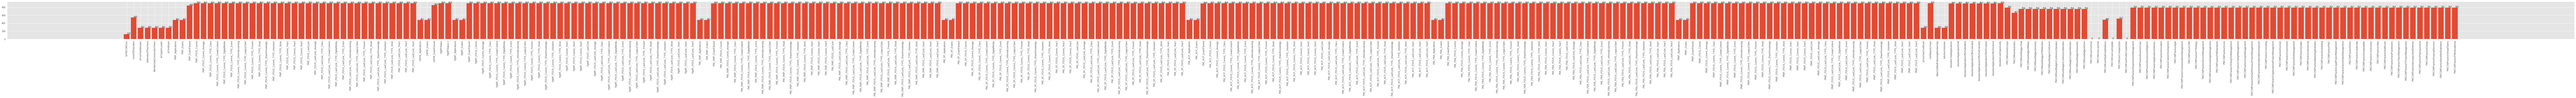

In [10]:
# Plot missing values for the float dataframe
plot_missing_values(data_flt)

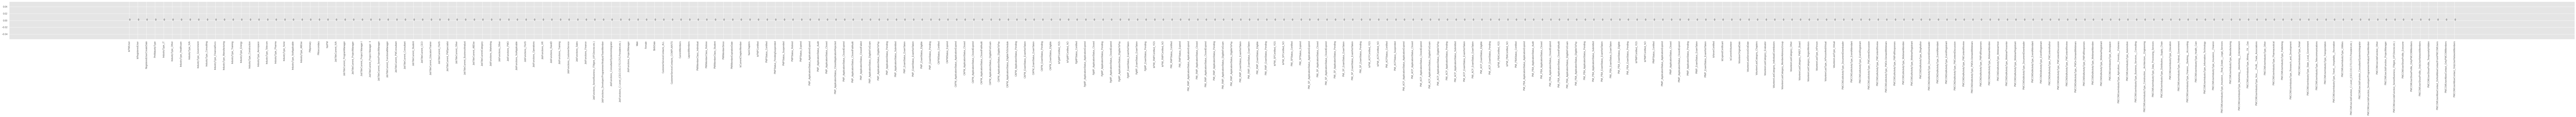

In [11]:
# Plot missing values for the int dataframe
plot_missing_values(data_int)

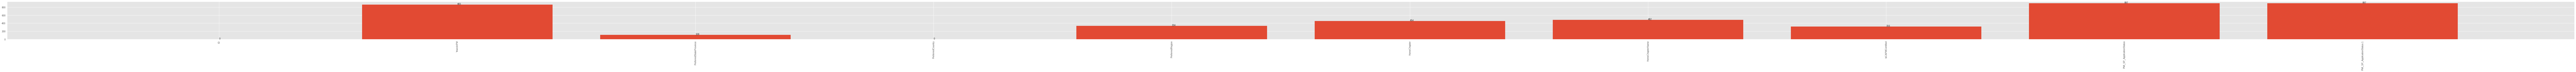

In [12]:
# Plot missing values for the object dataframe
plot_missing_values(data_obj)

### ii. Drop Missing Value Columns

The observation is that most of the columns in the float dataframe are completely missing. Most of the columns values that are entirely missing. And most of the other columns have most of their data missing. Only 4 columns of the float dataframe have values present.

The int dataframe has no missing values.

The object dataframe has missing values in most of the columns, with only 2 columns of complete data.

For the benefit of the customer segmentation task, all columns with incomplete data are dropped.

In [13]:
def drop_columns(df):
  for column in df:
    if df[column].notna().sum() != df.shape[0]:
      df.drop(column, axis = 1, inplace = True)
  return df

In [14]:
# Float dataframe
new_flt = drop_columns(data_flt)
new_flt.shape

(900, 4)

In [15]:
# Object dataframe
new_obj = drop_columns(data_obj)
new_obj.shape

(900, 2)

The object dataframe other column besides the ID column, is cleaned by unifyining the USA and UNITED STATES values and replacing the 0 value with UNKNOWN.

In [16]:
new_obj['PreferredCountry'].unique()

array(['USA', '0', 'UNITED STATES', 'INDIA'], dtype=object)

In [17]:
new_obj['PreferredCountry'] = new_obj['PreferredCountry'].replace('UNITED STATES', 'USA')
new_obj['PreferredCountry'] = new_obj['PreferredCountry'].replace('0', 'UNKNOWN')

I have used the LabelEncoder to encode the categorical values.

In [18]:
label_encoder1 = preprocessing.LabelEncoder()
new_obj['PreferredCountry'] = label_encoder1.fit_transform(new_obj['PreferredCountry'])

In [19]:
data_int.head()

,IsPMIUser,IsRegisteredUser,RegisteredUserCreateDate,PmMaturityType,IndustryType_IT,IndustryType_Other,IndustryType_Healthcare,IndustryType_N/A,IndustryType_Government,IndustryType_Consulting,IndustryType_FinancialSvcs,IndustryType_Manufacturing,IndustryType_Training,IndustryType_Energy,IndustryType_Construction,IndustryType_Aerospace,IndustryType_Telecom,IndustryType_Pharma,IndustryType_None,IndustryType_NotApplicable,IndustryType_AllElse,PMprimary,PMsecondary,NotPM,JobTitleCurrent_N/A,JobTitleCurrent_ProgramManager,JobTitleCurrent_ProjectManager,JobTitleCurrent_Project Manager I,JobTitleCurrent_Project Manager II,JobTitleCurrent_SeniorProjectManager,JobTitleCurrent_FunctionalManager,JobTitleCurrent_PMConsultant,JobTitleCurrent_Consultant,JobTitleCurrent_Student,JobTitleCurrent_CEO,JobTitleCurrent_Educator/Trainer,JobTitleCurrent_ITorIS,JobTitleCurrent_PMSpecialist,JobTitleCurrent_Other,JobTitleCurrent_BusinessAnalyst,JobTitleCurrent_AllElse,JobTitleCurrentCategory,JobFunctions_Marketing,JobFunctions_Other,JobFunctions_PMO,JobFunctions_NotApplicable,JobFunctions_ITorIS,JobFunctions_Operations,JobFunctions_HR,JobFunctions_RandD,JobFunctions_Training,JobFunctions_CustomerService,JobFunctions_Sales,JobFunctions_Finance,"JobFunctions_SeniorBusiness_ITMgmt_(VP,Director,etc.)",JobFunctions_Developer/Programmer/Analyst/TeamMember,JobFunctions_Consultant/SystemsIntegrator,"JobFunctions_C-Level_(CEO,CIO,CTO,CFO,President,etc.)",JobFunctions_ProjectManager,Male,Female,BirthDate,CustomerServiceContacts_ALL,CustomerServiceContacts_COMPLAINTS,CurrentMembers,LapsedMembers,PMIMemberClass_Individual,PMIMemberClass_Retiree,PMIMemberClass_Student,PMIMemberSince,PMIMemberExpirationDate,IsCurrentChapterMember,NumChapters,IsPMPCertified,PMPStatus_Certified,PMPStatus_PendingSuspended,PMPStatus_Suspended,PMPStatus_Retired,PMPStatus_Expired,PMP_ApplicationStatus_ApplicationExpired,PMP_ApplicationStatus_Audit,PMP_ApplicationStatus_Closed,PMP_ApplicationStatus_ClosedApplicationRejected,PMP_ApplicationStatus_ClosedExpired,PMP_ApplicationStatus_ClosedFailAudit,PMP_ApplicationStatus_ClosedFailed,PMP_ApplicationStatus_EligibleForExam,PMP_ApplicationStatus_EligibleToPay,PMP_ApplicationStatus_Pending,PMP_ApplicationStatus_Submitted,PMP_ExamStatus_ExamTaken,PMP_ExamStatus_ExamNotTaken,PMP_ExamStatus_Eligible,PMP_ExamStatus_Pending,CAPMStatus_Certified,CAPMStatus_Expired,CAPM_ApplicationStatus_ApplicationExpired,CAPM_ApplicationStatus_Closed,CAPM_ApplicationStatus_ClosedExpired,CAPM_ApplicationStatus_ClosedFailAudit,CAPM_ApplicationStatus_EligibleForExam,CAPM_ApplicationStatus_EligibleToPay,CAPM_ApplicationStatus_EligibleToSchedule,CAPM_ApplicationStatus_Pending,CAPM_ExamStatus_ExamNotTaken,CAPM_ExamStatus_ExamTaken,CAPM_ExamStatus_Pending,CAPM_ExamStatus_Eligible,IsPgMPCertified_YES,IsPgMPCertified_NO,PgMPStatus_Certified,PgMP_ApplicationStatus_ApplicationExpired,PgMP_ApplicationStatus_Closed,PgMP_ApplicationStatus_Pending,PgMP_ApplicationStatus_ClosedExpired,PgMP_ApplicationStatus_EligibleToPay,PgMP_ExamStatus_ExamNotTaken,PgMP_ExamStatus_ExamTaken,PgMP_ExamStatus_Pending,IsPMI_RMPCertified_YES,IsPMI_RMPCertified_NO,PMI_RMPStatus_Certified,PMI_RMPStatus_Expired,PMI_RMP_ApplicationStatus_ApplicationExpired,PMI_RMP_ApplicationStatus_Closed,PMI_RMP_ApplicationStatus_ClosedExpired,PMI_RMP_ApplicationStatus_Pending,PMI_RMP_ApplicationStatus_EligibleForExam,PMI_RMP_ApplicationStatus_EligibleToPay,PMI_RMP_ExamStatus_ExamNotTaken,PMI_RMP_ExamStatus_ExamTaken,PMI_RMP_ExamStatus_Eligible,PMI_RMP_ExamStatus_Pending,IsPMI_SPCertified_YES,IsPMI_SPCertified_NO,PMI_SPStatus_Certified,PMI_SPStatus_Expired,PMI_SP_ApplicationStatus_ApplicationExpired,PMI_SP_ApplicationStatus_Closed,PMI_SP_ApplicationStatus_ClosedExpired,PMI_SP_ApplicationStatus_Pending,PMI_SP_ExamStatus_ExamTaken,PMI_SP_ExamStatus_ExamNotTaken,PMI_SP_ExamStatus_Pending,IsPMI_ACPCertified_YES,IsPMI_ACPCertified_NO,PMI_ACPStatus_Certified,PMI_ACPStatus_Suspended,PMI_ACP_ApplicationStatus_ApplicationExpired,PMI

### iii. Reconstructing the dataset to decode the encoded features.

The int dataframe has a high number of columns. The observation is that over 50% of the colums have been dummy encoded. To handle the data for the int dataframe, I have reconstructed the dataset to compress the data and recover the categorical columns. 

On recovery, the dataset shall be label encoded.

I have used regular expressions to compile the categories and match encoded columns with their main columns to compress the previously dummy encoded features into categorical values.

In [20]:
int_cols = list(data_int.columns)

In [21]:
df1 = re.compile('PMCOMUserAllowContact*.')
df1list = list(filter(df1.match, int_cols)) 

df2 = re.compile('IndustryType*.')
df2list = list(filter(df2.match, int_cols)) 

df3 = re.compile('JobTitleCurrent*.')
df3list = list(filter(df3.match, int_cols))

df4 = re.compile('JobFunctions*.')
df4list = list(filter(df4.match, int_cols)) 

df5 = re.compile('CustomerServiceContacts*.')
df5list = list(filter(df5.match, int_cols)) 

df6 = re.compile('PMIMemberClass*.')
df6list = list(filter(df6.match, int_cols))

df7 = re.compile('PMPStatus*.')
df7list = list(filter(df7.match, int_cols)) 

df8 = re.compile('PMP_ApplicationStatus*.')
df8list = list(filter(df8.match, int_cols)) 

df9 = re.compile('PMP_ExamStatus*.')
df9list = list(filter(df9.match, int_cols))

df10 = re.compile('CAPMStatus*.')
df10list = list(filter(df10.match, int_cols)) 

df11 = re.compile('CAPM_ApplicationStatus*.')
df11list = list(filter(df11.match, int_cols)) 

df12 = re.compile('CAPM_ExamStatus*.')
df12list = list(filter(df12.match, int_cols))

df13 = re.compile('IsPgMPCertified*.')
df13list = list(filter(df13.match, int_cols)) 

df14 = re.compile('PgMP_ApplicationStatus*.')
df14list = list(filter(df14.match, int_cols)) 

df15 = re.compile('PgMP_ExamStatus*.')
df15list = list(filter(df15.match, int_cols))

df16 = re.compile('IsPMI_SPCertified*.')
df16list = list(filter(df16.match, int_cols)) 

df17 = re.compile('PMI_SPStatus*.')
df17list = list(filter(df17.match, int_cols)) 

df18 = re.compile('PMI_SP_ApplicationStatus*.')
df18list = list(filter(df18.match, int_cols))

df19 = re.compile('PMI_SP_ExamStatus*.')
df19list = list(filter(df19.match, int_cols)) 

df20 = re.compile('IsPMI_ACPCertified*.')
df20list = list(filter(df20.match, int_cols)) 

df21 = re.compile('PMI_ACP_ApplicationStatus*.')
df21list = list(filter(df21.match, int_cols))

df22 = re.compile('PMI_ACP_ExamStatus*.')
df22list = list(filter(df22.match, int_cols)) 

df23 = re.compile('PMI_PBA_ApplicationStatus*.')
df23list = list(filter(df23.match, int_cols)) 

df24 = re.compile('PMI_PBA_ExamStatus*.')
df24list = list(filter(df24.match, int_cols))

df25 = re.compile('IsPfMPCertified*.')
df25list = list(filter(df25.match, int_cols)) 

df26 = re.compile('PfMP_ApplicationStatus*.')
df26list = list(filter(df26.match, int_cols))

df27 = re.compile('PfMP_ExamStatus*.')
df27list = list(filter(df27.match, int_cols)) 

df28 = re.compile('VolunteerLastCategory*.')
df28list = list(filter(df28.match, int_cols)) 

df29 = re.compile('VolunteerLastType*.')
df29list = list(filter(df29.match, int_cols))

df30 = re.compile('PMCOM1stActivityType*.')
df30list = list(filter(df30.match, int_cols))

df31 = re.compile('PMCOM2ndActivityType*.')
df31list = list(filter(df31.match, int_cols)) 

df32 = re.compile('PMCOM3rdActivityType*.')
df32list = list(filter(df32.match, int_cols))

df33 = re.compile('PMCOMUserIndustryType*.')
df33list = list(filter(df33.match, int_cols)) 

df34 = re.compile('PMCOMUserJobFunction*.')
df34list = list(filter(df34.match, int_cols)) 

df35 = re.compile('PMCOMUserShowProfile*.')
df35list = list(filter(df35.match, int_cols))

A new dataframe has been created from the decoded features. The dataframe is compresed from 271 columns to 60 columns.

In [22]:
data_int1 = pd.DataFrame()

In [23]:
data_int1['IsPMIUser'] = data_int['IsPMIUser']
data_int1['IsRegisteredUser'] = data_int['IsRegisteredUser']
data_int1['PmMaturityType'] = data_int['PmMaturityType']
data_int1['RegisteredUserCreateDate'] = data_int['RegisteredUserCreateDate']
data_int1['BirthDate'] = data_int['BirthDate']
data_int1['CurrentMembers'] = data_int['CurrentMembers']
data_int1['NumChapters'] = data_int['NumChapters']
data_int1['Gender_Male'] = data_int['Male']
data_int1['Gender_Female'] = data_int['Female']
data_int1['CurrentMembers'] = data_int['CurrentMembers']
data_int1['LapsedMembers'] = data_int['LapsedMembers']
data_int1['PMIMemberSince'] = data_int['PMIMemberSince']
data_int1['PMIMemberExpirationDate'] = data_int['PMIMemberExpirationDate']
data_int1['IsCurrentChapterMember'] = data_int['IsCurrentChapterMember']
data_int1['NumChapters'] = data_int['NumChapters']
data_int1['IsPMPCertified'] = data_int['IsPMPCertified']
data_int1['IsNeverCertified'] = data_int['IsNeverCertified']
data_int1['IsExpiredCertificant'] = data_int['IsExpiredCertificant']
data_int1['VolunteerOriginalDate'] = data_int['VolunteerOriginalDate']
data_int1['IsCurrentVolunteer'] = data_int['IsCurrentVolunteer']
data_int1['VolunteerLastServiceEndDate'] = data_int['VolunteerLastServiceEndDate']
data_int1['PMprimary'] = data_int['PMprimary']
data_int1['PMsecondary'] = data_int['PMsecondary']
data_int1['NotPM'] = data_int['NotPM']
data_int1['IndustryType'] = (data_int[df2list].iloc[:, 1:] == 1).idxmax(1)
data_int1['JobTitleCurrent'] = (data_int[df3list].iloc[:, 1:] == 1).idxmax(1)
data_int1['JobFunctions'] = (data_int[df4list].iloc[:, 1:] == 1).idxmax(1)
data_int1['CustomerServiceContacts'] = (data_int[df5list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PMIMemberClass'] = (data_int[df6list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PMPStatus'] = (data_int[df7list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PMP_ApplicationStatus'] = (data_int[df8list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PMP_ExamStatus'] = (data_int[df9list].iloc[:, 1:] == 1).idxmax(1)
data_int1['CAPMStatus'] = (data_int[df10list].iloc[:, 1:] == 1).idxmax(1)
data_int1['CAPM_ApplicationStatus'] = (data_int[df11list].iloc[:, 1:] == 1).idxmax(1)
data_int1['CAPM_ExamStatus'] = (data_int[df12list].iloc[:, 1:] == 1).idxmax(1)
data_int1['IsPgMPCertified'] = (data_int[df13list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PgMPStatus_Certified'] = data_int['PgMPStatus_Certified']
data_int1['PgMP_ApplicationStatus'] = (data_int[df14list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PMI_RMP_ExamStatus'] = (data_int[df15list].iloc[:, 1:] == 1).idxmax(1)
data_int1['IsPMI_SPCertified'] = (data_int[df16list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PMI_SPStatus'] = (data_int[df17list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PMI_SP_ApplicationStatus'] = (data_int[df18list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PMI_SP_ExamStatus'] = (data_int[df19list].iloc[:, 1:] == 1).idxmax(1)
data_int1['IsPMI_ACPCertified'] = (data_int[df20list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PMI_ACP_ApplicationStatus'] = (data_int[df21list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PMI_ACP_ExamStatus'] = (data_int[df22list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PMI_PBAStatus_Certified'] = data_int['PMI_PBAStatus_Certified']
data_int1['PMI_PBA_ApplicationStatus'] = (data_int[df23list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PMI_PBA_ExamStatus'] = (data_int[df24list].iloc[:, 1:] == 1).idxmax(1)
data_int1['IsPfMPCertified'] = (data_int[df25list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PfMPStatus_Certified'] = data_int['PfMPStatus_Certified']
data_int1['PfMP_ApplicationStatus'] = (data_int[df26list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PfMP_ExamStatus'] = (data_int[df27list].iloc[:, 1:] == 1).idxmax(1)
data_int1['VolunteerLastCategory'] = (data_int[df28list].iloc[:, 1:] == 1).idxmax(1)
data_int1['VolunteerLastType'] = (data_int[df29list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PMCOM1stActivityType'] = (data_int[df30list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PMCOM2ndActivityType'] = (data_int[df31list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PMCOM3rdActivityType'] = (data_int[df32list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PMCOMUserIndustryType'] = (data_int[df33list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PMCOMUserJobFunction'] = (data_int[df34list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PMCOMUserShowProfile'] = (data_int[df35list].iloc[:, 1:] == 1).idxmax(1)
data_int1['PMCOMUserAllowContact'] = (data_int[df1list].iloc[:, 1:] == 1).idxmax(1)

### vi. Cleaning the newly created dataframe

On revovery, a lot of the columns and the values more or less in an irregular format. The formerly int dataframe now has both categorical and integer values. 

To handle this, I have split the dataframe by datatype(object and int64).

The categorical dataframe is further processed and Label Encoded.The prefixes attached leftwise, from the initial one-hot encoding are chopped off to reveal the acvtual row values. Further processing is done to reinstate the values that were over over striped.

In [24]:
data_int1_int = data_int1.select_dtypes(include = ['int64'])
data_int1_obj = data_int1.select_dtypes(include = ['object'])

In [25]:
data_int1_obj.head()

,IndustryType,JobTitleCurrent,JobFunctions,CustomerServiceContacts,PMIMemberClass,PMPStatus,PMP_ApplicationStatus,PMP_ExamStatus,CAPMStatus,CAPM_ApplicationStatus,CAPM_ExamStatus,IsPgMPCertified,PgMP_ApplicationStatus,PMI_RMP_ExamStatus,IsPMI_SPCertified,PMI_SPStatus,PMI_SP_ApplicationStatus,PMI_SP_ExamStatus,IsPMI_ACPCertified,PMI_ACP_ApplicationStatus,PMI_ACP_ExamStatus,PMI_PBA_ApplicationStatus,PMI_PBA_ExamStatus,IsPfMPCertified,PfMP_ApplicationStatus,PfMP_ExamStatus,VolunteerLastCategory,VolunteerLastType,PMCOM1stActivityType,PMCOM2ndActivityType,PMCOM3rdActivityType,PMCOMUserIndustryType,PMCOMUserJobFunction,PMCOMUserShowProfile,PMCOMUserAllowContact
0,IndustryType_AllElse,JobTitleCurrent_AllElse,JobFunctions_Developer/Programmer/Analyst/Team...,CustomerServiceContacts_COMPLAINTS,PMIMemberClass_Retiree,PMPStatus_PendingSuspended,PMP_ApplicationStatus_Audit,PMP_ExamStatus_ExamNotTaken,CAPMStatus_Expired,CAPM_ApplicationStatus_Closed,CAPM_ExamStatus_ExamTaken,IsPgMPCertified_NO,PgMP_ApplicationStatus_Closed,PgMP_ExamStatus_ExamTaken,IsPMI_SPCertified_NO,PMI_SPStatus_Expired,PMI_SP_ApplicationStatus_Closed,PMI_SP_ExamStatus_ExamNotTaken,IsPMI_ACPCertified_NO,PMI_ACP_ApplicationStatus_Closed,PMI_ACP_ExamStatus_ExamTaken,PMI_PBA_ApplicationStatus_Audit,PMI_PBA_ExamStatus_ExamTaken,IsPfMPCertified_NO,PfMP_ApplicationStatus_Closed,PfMP_ExamStatus_ExamNotTaken,VolunteerLastCategory_Evaluator,VolunteerLastType_InPersonAndVirtual,PMCOM1stActivityType_EventAttendant,PMCOM2ndActivityType_DocumentDownloader,PMCOM3rdActivityType_EventAttendant,PMCOMUserIndustryType_Business_Services__Consu...,PMCOMUserJobFunction_Developer/Programmer/Anal...,PMCOMUserShowProfile_OnlyPMCOMMembers,PMCOMUserAllowContact_OnlyPMCOMMembers
1,IndustryType_Other,JobTitleCurrent_AllElse,JobFunctions_ProjectManager,CustomerServiceContacts_COMPLAINTS,PMIMemberClass_Retiree,PMPStatus_PendingSuspended,PMP_ApplicationStatus_Audit,PMP_ExamStatus_ExamNotTaken,CAPMStatus_Expired,CAPM_ApplicationStatus_Closed,CAPM_ExamStatus_ExamTaken,IsPgMPCertified_NO,PgMP_ApplicationStatus_Closed,PgMP_ExamStatus_ExamTaken,IsPMI_SPCertified_NO,PMI_SPStatus_Expired,PMI_SP_ApplicationStatus_Closed,PMI_SP_ExamStatus_ExamNotTaken,IsPMI_ACPCertified_NO,PMI_ACP_ApplicationStatus_Closed,PMI_ACP_ExamStatus_ExamTaken,PMI_PBA_ApplicationStatus_Audit,PMI_PBA_ExamStatus_ExamTaken,IsPfMPCertified_NO,PfMP_ApplicationStatus_Closed,PfMP_ExamStatus_ExamNotTaken,VolunteerLastCategory_Evaluator,VolunteerLastType_InPersonAndVirtual,PMCOM1stActivityType_EventAttendant,PMCOM2ndActivityType_DocumentDownloader,PMCOM3rdActivityType_EventAttendant,PMCOMUserIndustryType_Utilities,PMCOMUserJobFunction_ProjectManager,PMCOMUserShowProfile_OnlyPMCOMMembers,PMCOMUserAllowContact_OnlyPMCOMMembers
2,IndustryType_Other,JobTitleCurrentCategory,JobFunctions_NotApplicable,CustomerServiceContacts_COMPLAINTS,PMIMemberClass_Retiree,PMPStatus_PendingSuspended,PMP_ApplicationStatus_Audit,PMP_ExamStatus_ExamNotTaken,CAPMStatus_Expired,CAPM_ApplicationStatus_Closed,CAPM_ExamStatus_ExamTaken,IsPgMPCertified_NO,PgMP_ApplicationStatus_Closed,PgMP_ExamStatus_ExamTaken,IsPMI_SPCertified_NO,PMI_SPStatus_Expired,PMI_SP_ApplicationStatus_Closed,PMI_SP_ExamStatus_ExamNotTaken,IsPMI_ACPCertified_NO,PMI_ACP_ApplicationStatus_Closed,PMI_ACP_ExamStatus_ExamTaken,PMI_PBA_ApplicationStatus_Audit,PMI_PBA_ExamStatus_ExamTaken,IsPfMPCertified_NO,PfMP_ApplicationStatus_Closed,PfMP_ExamStatus_ExamNotTaken,VolunteerLastCategory_Evaluator,VolunteerLastType_InPersonAndVirtual,PMCOM1stActivityType_WebinarRegistrant,PMCOM2ndActivityType_WebinarHost,PMCOM3rdActivityType_EventAttendant,PMCOMUserIndustryType_Non___Profit__Trade_Asso...,PMCOMUserJobFunction_Other,PMCOMUserShowProfile_OnlyPMCOMMembers,PMCOMUserAllowContact_OnlyPMCOMMembers
3,IndustryType_AllElse,JobTitleCurrent_AllElse,JobFunctions_Other,CustomerServiceContacts_COMPLAINTS,PMIMemberClass_Retiree,PMPStatus_PendingSuspended,PMP_ApplicationStatus_Audit,PMP_ExamStatus_ExamNotTaken,CAPMStatus_Expi

In [26]:
data_int1_obj['IndustryType'] = data_int1_obj['IndustryType'].map(lambda x: x.lstrip('IndustryType_'))
data_int1_obj['JobTitleCurrent'] = data_int1_obj['JobTitleCurrent'].map(lambda x: x.lstrip('JobTitleCurrent_'))
data_int1_obj['JobFunctions'] = data_int1_obj['JobFunctions'].map(lambda x: x.lstrip('JobFunctions_'))
data_int1_obj['CustomerServiceContacts'] = data_int1_obj['CustomerServiceContacts'].map(lambda x: x.lstrip('CustomerServiceContacts_'))
data_int1_obj['PMIMemberClass'] = data_int1_obj['PMIMemberClass'].map(lambda x: x.lstrip('PMIMemberClass_'))
data_int1_obj['PMPStatus'] = data_int1_obj['PMPStatus'].map(lambda x: x.lstrip('PMPStatus_'))
data_int1_obj['PMP_ApplicationStatus'] = data_int1_obj['PMP_ApplicationStatus'].map(lambda x: x.lstrip('PMP_ApplicationStatus_'))
data_int1_obj['PMP_ExamStatus'] = data_int1_obj['PMP_ExamStatus'].map(lambda x: x.lstrip('PMP_ExamStatus_'))
data_int1_obj['CAPMStatus'] = data_int1_obj['CAPMStatus'].map(lambda x: x.lstrip('CAPMStatus_'))
data_int1_obj['CAPM_ApplicationStatus'] = data_int1_obj['CAPM_ApplicationStatus'].map(lambda x: x.lstrip('CAPM_ApplicationStatus_'))
data_int1_obj['CAPM_ExamStatus'] = data_int1_obj['CAPM_ExamStatus'].map(lambda x: x.lstrip('CAPM_ExamStatus_'))
data_int1_obj['IsPgMPCertified'] = data_int1_obj['IsPgMPCertified'].map(lambda x: x.lstrip('IsPgMPCertified_'))
data_int1_obj['PgMP_ApplicationStatus'] = data_int1_obj['PgMP_ApplicationStatus'].map(lambda x: x.lstrip('PgMP_ApplicationStatus_'))
data_int1_obj['PMI_RMP_ExamStatus'] = data_int1_obj['PMI_RMP_ExamStatus'].map(lambda x: x.lstrip('PMI_RMP_ExamStatus_'))
data_int1_obj['IsPMI_SPCertified'] = data_int1_obj['IsPMI_SPCertified'].map(lambda x: x.lstrip('IsPMI_SPCertified_'))
data_int1_obj['PMI_SPStatus'] = data_int1_obj['PMI_SPStatus'].map(lambda x: x.lstrip('PMI_SPStatus_'))
data_int1_obj['PMI_SP_ApplicationStatus'] = data_int1_obj['PMI_SP_ApplicationStatus'].map(lambda x: x.lstrip('PMI_SP_ApplicationStatus_'))
data_int1_obj['PMI_SP_ExamStatus'] = data_int1_obj['PMI_SP_ExamStatus'].map(lambda x: x.lstrip('PMI_SP_ExamStatus_'))
data_int1_obj['IsPMI_ACPCertified'] = data_int1_obj['IsPMI_ACPCertified'].map(lambda x: x.lstrip('IsPMI_ACPCertified_'))
data_int1_obj['PMI_ACP_ApplicationStatus'] = data_int1_obj['PMI_ACP_ApplicationStatus'].map(lambda x: x.lstrip('PMI_ACP_ApplicationStatus_'))
data_int1_obj['PMI_ACP_ExamStatus'] = data_int1_obj['PMI_ACP_ExamStatus'].map(lambda x: x.lstrip('PMI_ACP_ExamStatus_'))
data_int1_obj['PMI_PBA_ApplicationStatus'] = data_int1_obj['PMI_PBA_ApplicationStatus'].map(lambda x: x.lstrip('PMI_PBA_ApplicationStatus_'))
data_int1_obj['PMI_PBA_ExamStatus'] = data_int1_obj['PMI_PBA_ExamStatus'].map(lambda x: x.lstrip('PMI_PBA_ExamStatus_'))
data_int1_obj['IsPfMPCertified'] = data_int1_obj['IsPfMPCertified'].map(lambda x: x.lstrip('IsPfMPCertified_'))
data_int1_obj['PfMP_ApplicationStatus'] = data_int1_obj['PfMP_ApplicationStatus'].map(lambda x: x.lstrip('PfMP_ApplicationStatus_'))
data_int1_obj['PfMP_ExamStatus'] = data_int1_obj['PfMP_ExamStatus'].map(lambda x: x.lstrip('PfMP_ExamStatus_'))
data_int1_obj['VolunteerLastCategory'] = data_int1_obj['VolunteerLastCategory'].map(lambda x: x.lstrip('VolunteerLastCategory_'))
data_int1_obj['VolunteerLastType'] = data_int1_obj['VolunteerLastType'].map(lambda x: x.lstrip('VolunteerLastType_'))
data_int1_obj['PMCOM1stActivityType'] = data_int1_obj['PMCOM1stActivityType'].map(lambda x: x.lstrip('PMCOM1stActivityType_'))
data_int1_obj['PMCOM2ndActivityType'] = data_int1_obj['PMCOM2ndActivityType'].map(lambda x: x.lstrip('PMCOM2ndActivityType_'))
data_int1_obj['PMCOM3rdActivityType'] = data_int1_obj['PMCOM3rdActivityType'].map(lambda x: x.lstrip('PMCOM3rdActivityType_'))
data_int1_obj['PMCOMUserIndustryType'] = data_int1_obj['PMCOMUserIndustryType'].map(lambda x: x.lstrip('PMCOMUserIndustryType_'))
data_int1_obj['PMCOMUserJobFunction'] = data_int1_obj['PMCOMUserJobFunction'].map(lambda x: x.lstrip('PMCOMUserJobFunction_'))
data_int1_obj['PMCOMUserShowProfile'] = data_int1_obj['PMCOMUserShowProfile'].map(lambda x: x.lstrip('PMCOMUserShowProfile_'))
data_int1_obj['PMCOMUserAllowContact'] = data_int1_obj['PMCOMUserAllowContact'].map(lambda x: x.lstrip('PMCOMUserAllowContact_'))

In [27]:
data_int1_obj['CustomerServiceContacts'] = data_int1_obj['CustomerServiceContacts'].replace('OMPLAINTS', 'COMPLAINTS')

data_int1_obj['PMPStatus'] = data_int1_obj['PMPStatus'].replace('endingSuspended', 'PendingSuspended')

data_int1_obj['PMP_ApplicationStatus'] = data_int1_obj['PMP_ApplicationStatus'].replace('dit', 'Audit')
data_int1_obj['PMP_ApplicationStatus'] = data_int1_obj['PMP_ApplicationStatus'].replace('ending', 'Pending')
data_int1_obj['PMP_ApplicationStatus'] = data_int1_obj['PMP_ApplicationStatus'].replace('bmitted', 'Submitted')

data_int1_obj['PMP_ExamStatus'] = data_int1_obj['PMP_ExamStatus'].replace('NotTaken', 'ExamNotTaken')
data_int1_obj['PMP_ExamStatus'] = data_int1_obj['PMP_ExamStatus'].replace('ligible', 'Eligible')
data_int1_obj['PMP_ExamStatus'] = data_int1_obj['PMP_ExamStatus'].replace('ending', 'Pending')

data_int1_obj['CAPM_ApplicationStatus'] = data_int1_obj['CAPM_ApplicationStatus'].replace('ed', 'Closed')
data_int1_obj['CAPM_ApplicationStatus'] = data_int1_obj['CAPM_ApplicationStatus'].replace('edExpired', 'ClosedExpired')
data_int1_obj['CAPM_ApplicationStatus'] = data_int1_obj['CAPM_ApplicationStatus'].replace('edFailAudit', 'ClosedFailAudit')
data_int1_obj['CAPM_ApplicationStatus'] = data_int1_obj['CAPM_ApplicationStatus'].replace('ending', 'Pending')

data_int1_obj['CAPM_ExamStatus'] = data_int1_obj['CAPM_ExamStatus'].replace('Taken', 'ExamTaken')
data_int1_obj['CAPM_ExamStatus'] = data_int1_obj['CAPM_ExamStatus'].replace('ending', 'Pending')
data_int1_obj['CAPM_ExamStatus'] = data_int1_obj['CAPM_ExamStatus'].replace('ligible', 'Eligible')

data_int1_obj['PgMP_ApplicationStatus'] = data_int1_obj['PgMP_ApplicationStatus'].replace('ending', 'Pending')

data_int1_obj['PMI_RMP_ExamStatus'] = data_int1_obj['PMI_RMP_ExamStatus'].replace('gMP_ExamStatus_ExamTaken', 'ExamTaken')

data_int1_obj['PMI_SP_ExamStatus'] = data_int1_obj['PMI_SP_ExamStatus'].replace('NotTaken', 'ExamNotTaken')

data_int1_obj['PMI_ACP_ApplicationStatus'] = data_int1_obj['PMI_ACP_ApplicationStatus'].replace('ed', 'Closed')
data_int1_obj['PMI_ACP_ApplicationStatus'] = data_int1_obj['PMI_ACP_ApplicationStatus'].replace('ligible', 'Eligible')
data_int1_obj['PMI_ACP_ApplicationStatus'] = data_int1_obj['PMI_ACP_ApplicationStatus'].replace('ending', 'Pending')

data_int1_obj['PMI_ACP_ExamStatus'] = data_int1_obj['PMI_ACP_ExamStatus'].replace('Taken', 'ExamTaken')
data_int1_obj['PMI_ACP_ExamStatus'] = data_int1_obj['PMI_ACP_ExamStatus'].replace('ligible', 'Eligible')

data_int1_obj['PMI_PBA_ApplicationStatus'] = data_int1_obj['PMI_PBA_ApplicationStatus'].replace('dit', 'Audit')
data_int1_obj['PMI_PBA_ApplicationStatus'] = data_int1_obj['PMI_PBA_ApplicationStatus'].replace('ending', 'Pending')

data_int1_obj['PMI_PBA_ExamStatus'] = data_int1_obj['PMI_PBA_ExamStatus'].replace('Taken', 'ExamTaken')

data_int1_obj['PfMP_ExamStatus'] = data_int1_obj['PfMP_ExamStatus'].replace('NotTaken', 'ExamNotTaken')

data_int1_obj['PMCOM1stActivityType'] = data_int1_obj['PMCOM1stActivityType'].replace('n-DemandWebinars', 'PMOn-DemandWebinars')
data_int1_obj['PMCOM1stActivityType'] = data_int1_obj['PMCOM1stActivityType'].replace('ontentDiscussion', 'PMContentDiscussion')
data_int1_obj['PMCOM1stActivityType'] = data_int1_obj['PMCOM1stActivityType'].replace('ollResponses', 'PMPollResponses')

data_int1_obj['PMCOM2ndActivityType'] = data_int1_obj['PMCOM2ndActivityType'].replace('n-DemandWebinars', 'PMOn-DemandWebinars')
data_int1_obj['PMCOM2ndActivityType'] = data_int1_obj['PMCOM2ndActivityType'].replace('ontentDiscussion', 'PMContentDiscussion')
data_int1_obj['PMCOM2ndActivityType'] = data_int1_obj['PMCOM2ndActivityType'].replace('ollResponses', 'PMPollResponses')

data_int1_obj['PMCOM3rdActivityType'] = data_int1_obj['PMCOM3rdActivityType'].replace('ontentDiscussion', 'PMContentDiscussion')
data_int1_obj['PMCOM3rdActivityType'] = data_int1_obj['PMCOM3rdActivityType'].replace('ontentReview', 'PMContentReview')

data_int1_obj['PMCOMUserIndustryType'] = data_int1_obj['PMCOMUserIndustryType'].replace('ilities', 'Utilities')
data_int1_obj['PMCOMUserIndustryType'] = data_int1_obj['PMCOMUserIndustryType'].replace('Non___Profit__Trade_Associations', 'Non_Profit_Trade_Associations')
data_int1_obj['PMCOMUserIndustryType'] = data_int1_obj['PMCOMUserIndustryType'].replace('onstruction__Architecture__Engineering', 'Construction_Architecture_Engineering')
data_int1_obj['PMCOMUserIndustryType'] = data_int1_obj['PMCOMUserIndustryType'].replace('her', 'Other')
data_int1_obj['PMCOMUserIndustryType'] = data_int1_obj['PMCOMUserIndustryType'].replace('avel__Hospitality__Recreation', 'Travel_Hospitality_Recreation')
data_int1_obj['PMCOMUserIndustryType'] = data_int1_obj['PMCOMUserIndustryType'].replace('formation_Technology', 'Information_Technology')
data_int1_obj['PMCOMUserIndustryType'] = data_int1_obj['PMCOMUserIndustryType'].replace('ansportation', 'Transportation')
data_int1_obj['PMCOMUserIndustryType'] = data_int1_obj['PMCOMUserIndustryType'].replace('arketing__Advertising__Entertainment', 'Marketing_Advertising_Entertainment')
data_int1_obj['PMCOMUserIndustryType'] = data_int1_obj['PMCOMUserIndustryType'].replace('Distribution__Supply_Chain', 'Distribution_Supply_Chain')
data_int1_obj['PMCOMUserIndustryType'] = data_int1_obj['PMCOMUserIndustryType'].replace('anufacturing', 'Manufacturing')
data_int1_obj['PMCOMUserIndustryType'] = data_int1_obj['PMCOMUserIndustryType'].replace('harmaceutical', 'Pharmaceutical')
data_int1_obj['PMCOMUserIndustryType'] = data_int1_obj['PMCOMUserIndustryType'].replace('lecommunications', 'Telecommunications')
data_int1_obj['PMCOMUserIndustryType'] = data_int1_obj['PMCOMUserIndustryType'].replace('ance__Real_Estate__Legal_Services', 'Insurance_Real_Estate_Legal_Services')
data_int1_obj['PMCOMUserIndustryType'] = data_int1_obj['PMCOMUserIndustryType'].replace('Finance__Banking__Accounting', 'Finance_Banking_Accounting')
data_int1_obj['PMCOMUserIndustryType'] = data_int1_obj['PMCOMUserIndustryType'].replace('ining__Oil__Gas', 'Mining_Oil_Gas')
data_int1_obj['PMCOMUserIndustryType'] = data_int1_obj['PMCOMUserIndustryType'].replace('ance__Finance', 'Insurance_Finance')
data_int1_obj['PMCOMUserIndustryType'] = data_int1_obj['PMCOMUserIndustryType'].replace('blishing', 'Publishing')
data_int1_obj['PMCOMUserIndustryType'] = data_int1_obj['PMCOMUserIndustryType'].replace('Business_Services__Consulting', 'Business_Services_Consulting')

data_int1_obj['PMCOMUserJobFunction'] = data_int1_obj['PMCOMUserJobFunction'].replace('jectManager', 'ProjectManager')
data_int1_obj['PMCOMUserJobFunction'] = data_int1_obj['PMCOMUserJobFunction'].replace('her', 'Other')
data_int1_obj['PMCOMUserJobFunction'] = data_int1_obj['PMCOMUserJobFunction'].replace('ltant/SystemsIntegrator', 'Consultant/SystemsIntegrator')


data_int1_obj['PMCOMUserShowProfile'] = data_int1_obj['PMCOMUserShowProfile'].replace('nlyPMCOMMembers', 'OnlyPMCOMMembers')
data_int1_obj['PMCOMUserShowProfile'] = data_int1_obj['PMCOMUserShowProfile'].replace('nlyUserNetworkMembers', 'OnlyUserNetworkMembers')

data_int1_obj['PMCOMUserAllowContact'] = data_int1_obj['PMCOMUserAllowContact'].replace('yPMCOMMembers', 'OnlyPMCOMMembers')
data_int1_obj['PMCOMUserAllowContact'] = data_int1_obj['PMCOMUserAllowContact'].replace('yUserNetworkMembers', 'OnlyUserNetworkMembers')

## **2. Feature Selection**

Though the int dataframe was successfully compressed from 271 columns, a lot of processing still has to be done as the data is still very highly dimensional and sparse. 

To manage the this, I shall employ a feature selection technique to enable me identify and select feature  with a seemingly high discriminative power among the set of all features.

### i. Feature Selection with Variance Threshold to remove zero-variance columns

As clustering is an unsupervised machine learning task, the most ideal feature selection technique is the **Variance Threshold** technique. 

The Variance Threshold technique of feature selection is a baseline technique. It simply removes all features with a  variance that does not meet a set threshold.

There are columns in the int dataframe that entirely filled with zeros. They have the same value of zero across all rows. These columns have no variance because there is no variability through the rows, moreso, these zero-variance columns are redundant and cannot contribute anything to the performance of the model.

I shall use a threshold set at 0 to identify and remove these columns.

In [28]:
# Instantiate Variance threshold and fit it on the dataframe.
# Threshold value set at 0
selector1 = VarianceThreshold(threshold = 0)
selector1.fit_transform(data_int1_int)

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [29]:
# This method allows us to identify the zero-variance columns
selector1.get_support()

array([ True,  True,  True,  True,  True, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False])

In [30]:
data_int1_int.columns[selector1.get_support()]

# Isolate the redundant columns with a variance = 0
zero_var_columns = [column for column in data_int1_int.columns if column 
                    not in data_int1_int.columns[selector1.get_support()]]

# Drop redundant columns
data_int1_int = data_int1_int.drop(zero_var_columns, axis = 1)
data_int1_int.head()

,IsPMIUser,IsRegisteredUser,PmMaturityType,RegisteredUserCreateDate,BirthDate,Gender_Male,Gender_Female,PMprimary,PMsecondary
0,0,1,0,233,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,1,1,0,176,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0


Label Encoding the Decoded dataframe of categorical data 

### ii. Feature Selection with Variance Threshold to remove constant-variance columns

In [31]:
# Instantiate label encoder and fit it to the data
label_encoder2 = preprocessing.LabelEncoder()
data_int1_obj_encoded = data_int1_obj.apply(label_encoder2.fit_transform)

Again, some columns with a constant variance have been identified have been. The Variance Threshold technique shall be employed to identify and select the useful columns.

In [32]:
# Instantiate Variance threshold and fit it on the dataframe.
# Threshold value set at 0
selector2 = VarianceThreshold(threshold = 0)
selector2.fit_transform(data_int1_obj_encoded)

array([[ 1,  0,  3, ...,  1,  0,  0],
       [12,  0, 10, ...,  3,  0,  0],
       [12, 12,  6, ...,  2,  0,  0],
       ...,
       [ 1, 12, 10, ...,  3,  0,  0],
       [ 1, 12,  3, ...,  1,  0,  0],
       [ 1, 12, 12, ...,  4,  2,  0]])

In [33]:
# This method allows us to identify the columns with a constant variance
selector2.get_support()

array([ True,  True,  True, False, False, False,  True,  True, False,
        True,  True, False,  True, False, False, False, False, False,
       False,  True,  True,  True, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True])

In [34]:
data_int1_obj_encoded.columns[selector2.get_support()]

# Isolate columns with a constant variance, i.e. variance = 1
low_var_columns = [column for column in data_int1_obj_encoded.columns if column 
                    not in data_int1_obj_encoded.columns[selector2.get_support()]]

# Drop redundant columns
data_int1_obj_encoded = data_int1_obj_encoded.drop(low_var_columns, axis = 1)
data_int1_obj.head()

,IndustryType,JobTitleCurrent,JobFunctions,CustomerServiceContacts,PMIMemberClass,PMPStatus,PMP_ApplicationStatus,PMP_ExamStatus,CAPMStatus,CAPM_ApplicationStatus,CAPM_ExamStatus,IsPgMPCertified,PgMP_ApplicationStatus,PMI_RMP_ExamStatus,IsPMI_SPCertified,PMI_SPStatus,PMI_SP_ApplicationStatus,PMI_SP_ExamStatus,IsPMI_ACPCertified,PMI_ACP_ApplicationStatus,PMI_ACP_ExamStatus,PMI_PBA_ApplicationStatus,PMI_PBA_ExamStatus,IsPfMPCertified,PfMP_ApplicationStatus,PfMP_ExamStatus,VolunteerLastCategory,VolunteerLastType,PMCOM1stActivityType,PMCOM2ndActivityType,PMCOM3rdActivityType,PMCOMUserIndustryType,PMCOMUserJobFunction,PMCOMUserShowProfile,PMCOMUserAllowContact
0,AllElse,AllElse,Developer/Programmer/Analyst/TeamMember,COMPLAINTS,Retiree,PendingSuspended,Audit,ExamNotTaken,Expired,Closed,ExamTaken,NO,Closed,ExamTaken,NO,Expired,Closed,ExamNotTaken,NO,Closed,ExamTaken,Audit,ExamTaken,NO,Closed,ExamNotTaken,Evaluator,InPersonAndVirtual,EventAttendant,DocumentDownloader,EventAttendant,Business_Services_Consulting,Developer/Programmer/Analyst/TeamMember,OnlyPMCOMMembers,OnlyPMCOMMembers
1,Other,AllElse,ProjectManager,COMPLAINTS,Retiree,PendingSuspended,Audit,ExamNotTaken,Expired,Closed,ExamTaken,NO,Closed,ExamTaken,NO,Expired,Closed,ExamNotTaken,NO,Closed,ExamTaken,Audit,ExamTaken,NO,Closed,ExamNotTaken,Evaluator,InPersonAndVirtual,EventAttendant,DocumentDownloader,EventAttendant,Utilities,ProjectManager,OnlyPMCOMMembers,OnlyPMCOMMembers
2,Other,ategory,NotApplicable,COMPLAINTS,Retiree,PendingSuspended,Audit,ExamNotTaken,Expired,Closed,ExamTaken,NO,Closed,ExamTaken,NO,Expired,Closed,ExamNotTaken,NO,Closed,ExamTaken,Audit,ExamTaken,NO,Closed,ExamNotTaken,Evaluator,InPersonAndVirtual,WebinarRegistrant,WebinarHost,EventAttendant,Non_Profit_Trade_Associations,Other,OnlyPMCOMMembers,OnlyPMCOMMembers
3,AllElse,AllElse,Other,COMPLAINTS,Retiree,PendingSuspended,Audit,ExamNotTaken,Expired,Closed,ExamTaken,NO,Closed,ExamTaken,NO,Expired,Closed,ExamNotTaken,NO,Closed,ExamTaken,Audit,ExamTaken,NO,Closed,ExamNotTaken,Evaluator,InPersonAndVirtual,EventAttendant,DocumentDownloader,EventAttendant,Education,Other,OnlyPMCOMMembers,OnlyPMCOMMembers
4,AllElse,ProjectManager,ProjectManager,COMPLAINTS,Retiree,PendingSuspended,Audit,ExamNotTaken,Expired,Closed,ExamTaken,NO,Closed,ExamTaken,NO,Expired,Closed,ExamNotTaken,NO,Closed,ExamTaken,Audit,ExamTaken,NO,Closed,ExamNotTaken,Evaluator,InPersonAndVirtual,EventAttendant,DocumentDownloader,EventAttendant,Construction_Architecture_Engineering,ProjectManager,OnlyPMCOMMembers,OnlyPMCOMMembers


In [35]:
# Concatenate the processed columns newly label encoded, formerly categorical datagframe to the int dataframe
data_int2 = pd.concat([data_int1_int, data_int1_obj_encoded], axis = 1)

In [36]:
# Concatenate all dataframes - cleaned float dataframe, cleaned int dataframe and the cleaned/label encoded object dataframe
final_data = pd.concat([new_obj, data_int2, new_flt], axis = 1)

In [37]:
# Make a copy of the final dataframe
final_data_copy = final_data.copy()

# Drop the ID column
final_data1 = final_data.drop(columns = ['ID', 'BirthDate'])
final_data1.head()

,PreferredCountry,IsPMIUser,IsRegisteredUser,PmMaturityType,RegisteredUserCreateDate,Gender_Male,Gender_Female,PMprimary,PMsecondary,IndustryType,JobTitleCurrent,JobFunctions,PMP_ApplicationStatus,PMP_ExamStatus,CAPM_ApplicationStatus,CAPM_ExamStatus,PgMP_ApplicationStatus,PMI_ACP_ApplicationStatus,PMI_ACP_ExamStatus,PMI_PBA_ApplicationStatus,PMCOM1stActivityType,PMCOM2ndActivityType,PMCOM3rdActivityType,PMCOMUserIndustryType,PMCOMUserJobFunction,PMCOMUserShowProfile,PMCOMUserAllowContact,PMCOMUserFirstVisit,PMCOMUserLastVisit,PMCOMUserLastUpdate,PMCOMUserProfileCreateDate
0,2,0,1,0,233,0,0,0,0,1,0,3,0,1,0,1,0,0,1,0,0,1,0,2,1,0,0,16.6,1.6,16.6,7.7
1,2,0,0,0,0,0,0,0,0,12,0,10,0,1,0,1,0,0,1,0,0,1,0,26,3,0,0,44.2,41.0,44.2,0.0
2,1,1,1,0,176,0,1,0,0,12,12,6,0,1,0,1,0,0,1,0,5,6,0,16,2,0,0,20.5,1.6,3.8,5.8
3,2,0,0,0,0,0,0,0,0,1,0,8,0,1,0,1,0,0,1,0,0,1,0,6,2,0,0,94.7,94.7,94.7,0.0
4,2,0,0,0,0,0,0,0,0,1,9,10,0,1,0,1,0,0,1,0,0,1,0,3,3,0,0,15.6,13.9,9.3,0.0


In [38]:
final_data1.shape

(900, 31)

### iii. Feature Selection with Variance Threshold to remove low-variance columns

The new dataframe still has some redundant columns. While these columns are not constant (i.e. have zero-variance), they do not have a lot of variability. They have a variance = 1, which is still a low variance value. 

These columns shall be identified and removed from the final dataframe to get ot ready for modelling.

In [39]:
final_data1.head()

,PreferredCountry,IsPMIUser,IsRegisteredUser,PmMaturityType,RegisteredUserCreateDate,Gender_Male,Gender_Female,PMprimary,PMsecondary,IndustryType,JobTitleCurrent,JobFunctions,PMP_ApplicationStatus,PMP_ExamStatus,CAPM_ApplicationStatus,CAPM_ExamStatus,PgMP_ApplicationStatus,PMI_ACP_ApplicationStatus,PMI_ACP_ExamStatus,PMI_PBA_ApplicationStatus,PMCOM1stActivityType,PMCOM2ndActivityType,PMCOM3rdActivityType,PMCOMUserIndustryType,PMCOMUserJobFunction,PMCOMUserShowProfile,PMCOMUserAllowContact,PMCOMUserFirstVisit,PMCOMUserLastVisit,PMCOMUserLastUpdate,PMCOMUserProfileCreateDate
0,2,0,1,0,233,0,0,0,0,1,0,3,0,1,0,1,0,0,1,0,0,1,0,2,1,0,0,16.6,1.6,16.6,7.7
1,2,0,0,0,0,0,0,0,0,12,0,10,0,1,0,1,0,0,1,0,0,1,0,26,3,0,0,44.2,41.0,44.2,0.0
2,1,1,1,0,176,0,1,0,0,12,12,6,0,1,0,1,0,0,1,0,5,6,0,16,2,0,0,20.5,1.6,3.8,5.8
3,2,0,0,0,0,0,0,0,0,1,0,8,0,1,0,1,0,0,1,0,0,1,0,6,2,0,0,94.7,94.7,94.7,0.0
4,2,0,0,0,0,0,0,0,0,1,9,10,0,1,0,1,0,0,1,0,0,1,0,3,3,0,0,15.6,13.9,9.3,0.0


In [40]:
# Instantiate Variance threshold and fit it on the dataframe.
# Threshold value set at 1
selector3 = VarianceThreshold(threshold = 1)
selector3.fit_transform(final_data1)

array([[2.330e+02, 1.000e+00, 0.000e+00, ..., 1.600e+00, 1.660e+01,
        7.700e+00],
       [0.000e+00, 1.200e+01, 0.000e+00, ..., 4.100e+01, 4.420e+01,
        0.000e+00],
       [1.760e+02, 1.200e+01, 1.200e+01, ..., 1.600e+00, 3.800e+00,
        5.800e+00],
       ...,
       [0.000e+00, 1.000e+00, 1.200e+01, ..., 1.935e+02, 0.000e+00,
        0.000e+00],
       [3.249e+03, 1.000e+00, 1.200e+01, ..., 1.600e+00, 2.680e+01,
        1.067e+02],
       [3.270e+03, 1.000e+00, 1.200e+01, ..., 8.410e+01, 7.780e+01,
        1.074e+02]])

In [41]:
# This method allows us to identify the columns with a variance of 1
selector3.get_support()

array([False, False, False, False,  True, False, False, False, False,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
        True,  True,  True,  True])

In [42]:
final_data1.columns[selector3.get_support()]

# Isolate the columns with a variance = 1
var_one_columns = [column for column in final_data1.columns if column 
                    not in final_data1.columns[selector3.get_support()]]

# Drop redundant columns
final_data1 = final_data1.drop(var_one_columns, axis = 1)
final_data1.head()

,RegisteredUserCreateDate,IndustryType,JobTitleCurrent,JobFunctions,PMP_ApplicationStatus,PMCOMUserIndustryType,PMCOMUserJobFunction,PMCOMUserFirstVisit,PMCOMUserLastVisit,PMCOMUserLastUpdate,PMCOMUserProfileCreateDate
0,233,1,0,3,0,2,1,16.6,1.6,16.6,7.7
1,0,12,0,10,0,26,3,44.2,41.0,44.2,0.0
2,176,12,12,6,0,16,2,20.5,1.6,3.8,5.8
3,0,1,0,8,0,6,2,94.7,94.7,94.7,0.0
4,0,1,9,10,0,3,3,15.6,13.9,9.3,0.0


In [43]:
final_data1.describe().T

,count,mean,std,min,25%,50%,75%,max
RegisteredUserCreateDate,900.0,791.065556,978.286399,0.0,0.0,320.5,1388.500,5335.0
IndustryType,900.0,7.338889,4.637186,0.0,2.0,8.0,12.000,15.0
JobTitleCurrent,900.0,7.797778,4.477753,0.0,4.0,9.0,12.000,13.0
JobFunctions,900.0,7.880000,2.217596,0.0,8.0,8.0,8.000,13.0
PMP_ApplicationStatus,900.0,0.411111,1.202467,0.0,0.0,0.0,0.000,6.0
PMCOMUserIndustryType,900.0,3.502222,6.372301,0.0,0.0,0.0,6.000,26.0
PMCOMUserJobFunction,900.0,1.066667,1.404743,0.0,0.0,0.0,3.000,4.0
PMCOMUserFirstVisit,900.0,22.686222,43.810611,0.0,0.0,0.0,22.400,206.3
PMCOMUserLastVisit,900.0,16.304333,35.334274,0.0,0.0,0.0,12.025,193.5
PMCOMUserLastUpdate,900.0,16.162444,33.323421,0.0,0.0,0.0,14.100,172.2


## **3. Preprocessing**

### i. Scaling with RobustScaler

KMeans uses distance-based measurements to determine the similarity between data points. This implies that KMeans is highly sensitive to outliers.

The RobustScaler is recommended because it is robust to outliers. 



In [44]:
# Instantiate Standard Scaler and fit on the data
scaler = RobustScaler()
final_data_scaled = scaler.fit(final_data1)
final_data_scaled = scaler.transform(final_data1)
final_data2 = pd.DataFrame(final_data_scaled, columns = final_data1.columns)
final_data2.head()

,RegisteredUserCreateDate,IndustryType,JobTitleCurrent,JobFunctions,PMP_ApplicationStatus,PMCOMUserIndustryType,PMCOMUserJobFunction,PMCOMUserFirstVisit,PMCOMUserLastVisit,PMCOMUserLastUpdate,PMCOMUserProfileCreateDate
0,-0.063018,-0.7,-1.125,-5.0,0.0,0.333333,0.333333,0.741071,0.133056,1.177305,7.7
1,-0.230825,0.4,-1.125,2.0,0.0,4.333333,1.000000,1.973214,3.409563,3.134752,0.0
2,-0.104069,0.4,0.375,-2.0,0.0,2.666667,0.666667,0.915179,0.133056,0.269504,5.8
3,-0.230825,-0.7,-1.125,0.0,0.0,1.000000,0.666667,4.227679,7.875260,6.716312,0.0
4,-0.230825,-0.7,0.000,2.0,0.0,0.500000,1.000000,0.696429,1.155925,0.659574,0.0


### ii. Silhouette Analysis

Initialize and plot the initializations for the KMeans clusters using the Silhouette visualizer.

The Silhouette analysis has been used to find the optimal number of clusters by determining the degree of separation between clusters. For each sample:
- The average distance from all data points within the same cluster was computed.
- The average distance from all data points in the neighouring cluster was computed.
- The Silhouette coefficient was computed.

The Silhouette coefficient ideally ranges between -1 and 1. Our Silhouette coefficient (silhouette score) is **0.664**. As seen in the Silhoette plot below, as the number of clusters becomes optimal, there is a better seperation between the clusters. **The optimal number of clusters, k is equal to 6.**

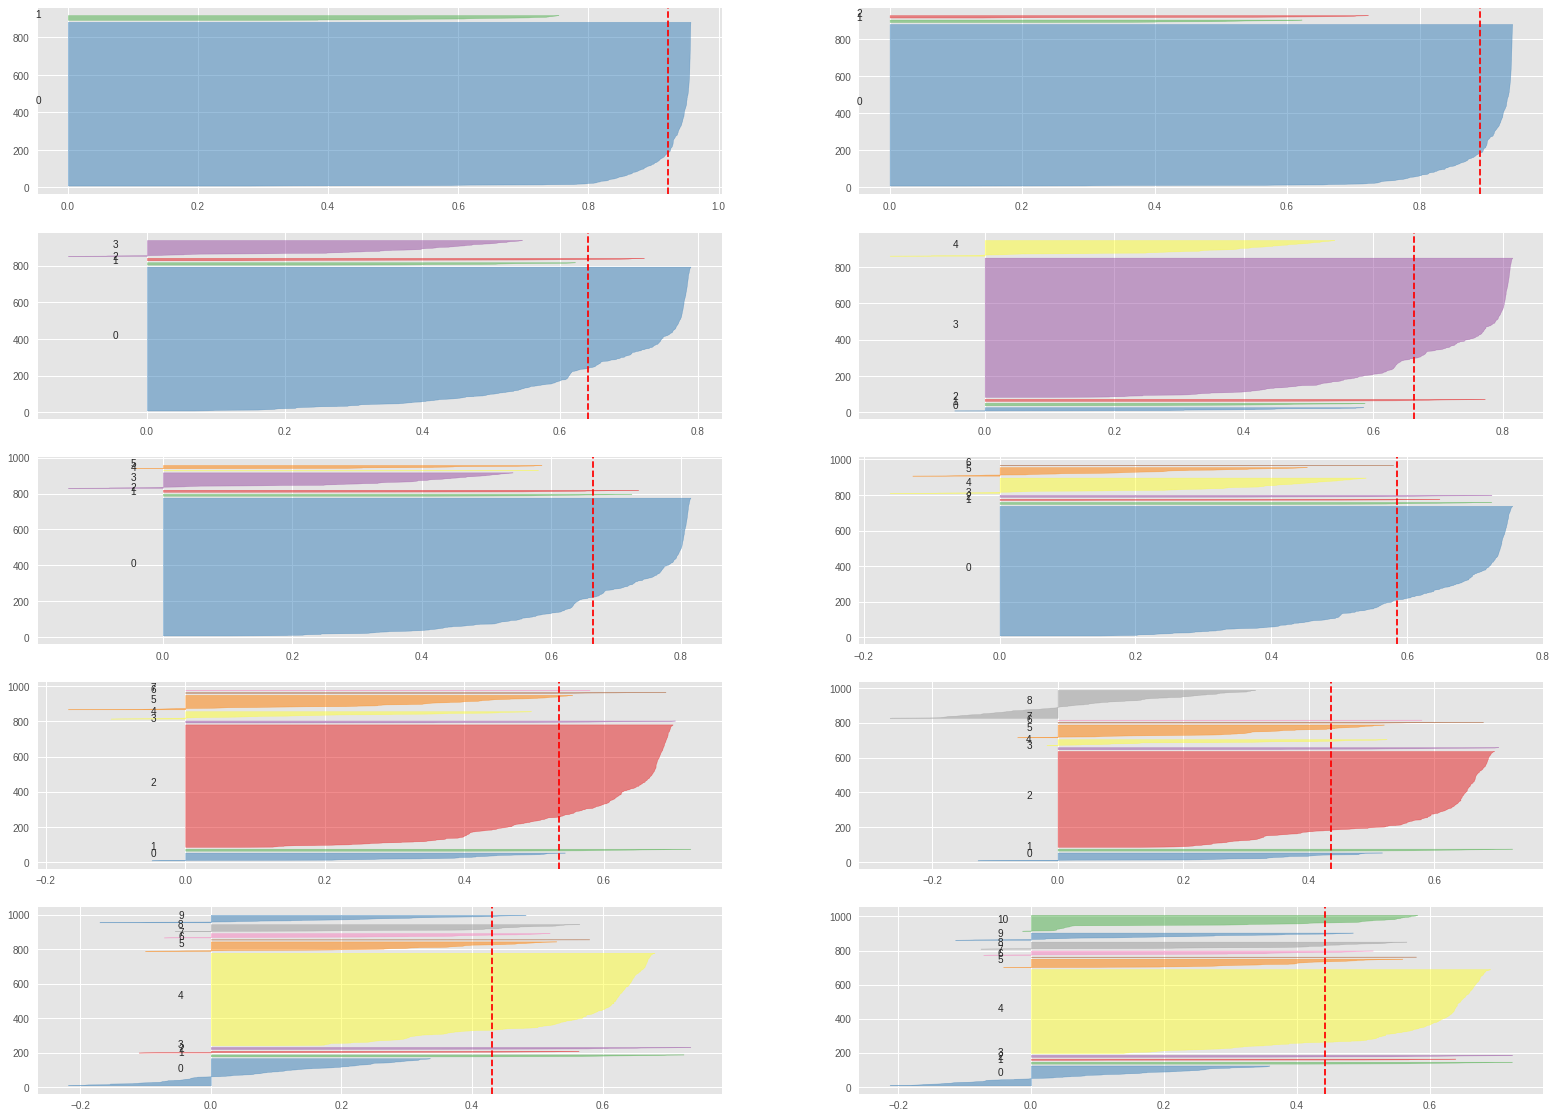

In [45]:
fig, ax = plt.subplots(5, 2, figsize = (27, 20))
for i in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters = i, init='k-means++', n_init = 10, max_iter = 100, random_state = 42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors = 'yellowbrick', ax = ax[q-1][mod])
    visualizer.fit(final_data2) 

In [46]:
num_clusters = 6

# Instantiate the KMeans algorithm
kmeans = KMeans(n_clusters = num_clusters, random_state = 42)
kmeans.fit_predict(final_data2)

array([0, 0, 0, 3, 0, 0, 3, 2, 0, 3, 0, 0, 0, 0, 2, 0, 5, 0, 3, 0, 3, 0,
       0, 5, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 3,

In [47]:
# Labels of each point
labels = kmeans.labels_

In [48]:
# Calculate the Silhouette score
score = silhouette_score(final_data2, labels, metric = 'euclidean')

# Print the score
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.664


In [49]:
# Cluster center 0f co-ordinates
kmeans.cluster_centers_.shape
print(kmeans.cluster_centers_.shape)
centroids = pd.DataFrame(data = kmeans.cluster_centers_, columns = list(final_data2.columns))        
centroids.head()

(6, 11)


,RegisteredUserCreateDate,IndustryType,JobTitleCurrent,JobFunctions,PMP_ApplicationStatus,PMCOMUserIndustryType,PMCOMUserJobFunction,PMCOMUserFirstVisit,PMCOMUserLastVisit,PMCOMUserLastUpdate,PMCOMUserProfileCreateDate
0,0.351663,0.000391,-0.098633,0.007813,4.674479e-01,0.422960,0.301649,0.353649,0.385124,0.395686,0.383203
1,2.122314,-0.525000,-0.291667,-0.750000,-5.551115e-17,1.819444,0.694444,5.390253,5.718642,5.832742,107.325000
2,1.330813,-0.366667,0.052083,-0.833333,2.500000e-01,1.388889,0.611111,3.364211,3.834373,3.867021,71.241667
3,-0.198829,-0.504598,-0.620690,-0.885057,4.597701e-02,1.563218,0.685824,5.756671,8.922121,6.625418,0.000000
4,3.307526,-0.300000,-0.562500,-2.500000,0.000000e+00,0.666667,0.166667,7.207589,5.384615,5.971631,161.450000


In [50]:
# Inverse transform the clusters and data
inversed_centroids = scaler.inverse_transform(kmeans.cluster_centers_)
inversed_centroids = pd.DataFrame(data = inversed_centroids, columns = list(final_data2.columns))
inversed_centroids

,RegisteredUserCreateDate,IndustryType,JobTitleCurrent,JobFunctions,PMP_ApplicationStatus,PMCOMUserIndustryType,PMCOMUserJobFunction,PMCOMUserFirstVisit,PMCOMUserLastVisit,PMCOMUserLastUpdate,PMCOMUserProfileCreateDate
0,808.783854,8.003906,8.210938,8.007813,4.674479e-01,2.537760,0.904948,7.921745,4.631120,5.579167,0.383203
1,3267.333333,2.750000,6.666667,7.250000,-5.551115e-17,10.916667,2.083333,120.741667,68.766667,82.241667,107.325000
2,2168.333333,4.333333,9.416667,7.166667,2.500000e-01,8.333333,1.833333,75.358333,46.108333,54.525000,71.241667
3,44.425287,2.954023,4.034483,7.114943,4.597701e-02,9.379310,2.057471,128.949425,107.288506,93.418391,0.000000
4,4913.000000,5.000000,4.500000,5.500000,0.000000e+00,4.000000,0.500000,161.450000,64.750000,84.200000,161.450000
5,626.000000,5.578947,8.368421,7.315789,2.105263e-01,7.789474,2.000000,23.105263,14.478947,17.073684,20.552632


In [51]:
# Concatenate the clusters to the original dataframes - scaled
final_data_clusters = pd.concat([final_data2, pd.DataFrame(labels, columns = ['Cluster'])], axis = 1)
final_data_clusters.head()

,RegisteredUserCreateDate,IndustryType,JobTitleCurrent,JobFunctions,PMP_ApplicationStatus,PMCOMUserIndustryType,PMCOMUserJobFunction,PMCOMUserFirstVisit,PMCOMUserLastVisit,PMCOMUserLastUpdate,PMCOMUserProfileCreateDate,Cluster
0,-0.063018,-0.7,-1.125,-5.0,0.0,0.333333,0.333333,0.741071,0.133056,1.177305,7.7,0
1,-0.230825,0.4,-1.125,2.0,0.0,4.333333,1.000000,1.973214,3.409563,3.134752,0.0,0
2,-0.104069,0.4,0.375,-2.0,0.0,2.666667,0.666667,0.915179,0.133056,0.269504,5.8,0
3,-0.230825,-0.7,-1.125,0.0,0.0,1.000000,0.666667,4.227679,7.875260,6.716312,0.0,3
4,-0.230825,-0.7,0.000,2.0,0.0,0.500000,1.000000,0.696429,1.155925,0.659574,0.0,0


In [52]:
final_data2.shape

(900, 11)

## **4. Model Development**

### i. Dimensionality Reduction with Principal Components

The features values are sparsely distributed. I have used PCA to compress the data to a lower dimension. In the plot of Principal Components, we can see that PCA also gives us 6 clusters.

In [53]:
pca = PCA(n_components = 2, random_state = 42)

#Transform the data
final_data2_pca = pca.fit_transform(final_data2)
final_data2_pca_df = pd.DataFrame(final_data2_pca, columns = ['PC1', 'PC2'])

# Include the clusters
final_data2_pca_df['Cluster'] = labels

print(final_data2_pca_df.shape)
print(pca.explained_variance_ratio_)
final_data2_pca_df.head()

(900, 3)
[0.91780554 0.04950848]


,PC1,PC2,Cluster
0,4.173027,-0.902480,0
1,-3.275714,3.580213,0
2,2.242530,-1.161216,0
3,-2.886814,9.357586,3
4,-3.554598,-0.323182,0


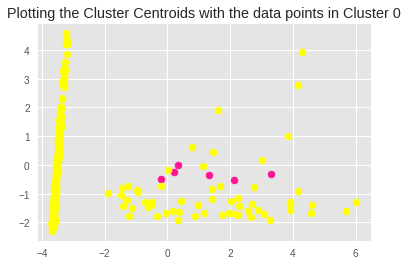

In [54]:
# Filter the rows of original data
label0 = final_data2_pca_df[final_data2_pca_df['Cluster'] == 0]
plt.title('Plotting the Cluster Centroids with the data points in Cluster 0')

#Plotting the cluster centroids
plt.scatter(centroids.iloc[:, 0] , centroids.iloc[:, 1], color = 'deeppink')

# Plotting the observations of cluster 0
plt.scatter(label0.iloc[:, 0] , label0.iloc[:, 1], color = 'yellow')

plt.show()

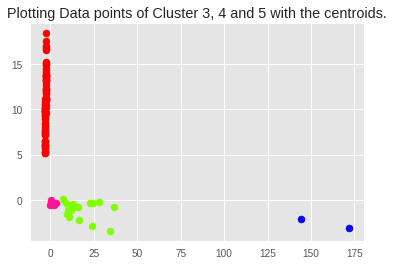

In [55]:
#filter rows of original data
label3 = final_data2_pca_df[final_data2_pca_df['Cluster'] == 3]
label4 = final_data2_pca_df[final_data2_pca_df['Cluster'] == 4]
label5 = final_data2_pca_df[final_data2_pca_df['Cluster'] == 5]

plt.title('Plotting Data points of Cluster 3, 4 and 5 with the centroids.')

#Plotting the cluster centroids
plt.scatter(centroids.iloc[:, 0] , centroids.iloc[:, 1], color = 'deeppink')

# Plotting additional clusters
plt.scatter(label3.iloc[:, 0] , label3.iloc[:, 1] , color = 'red')
plt.scatter(label4.iloc[:, 0] , label4.iloc[:, 1] , color = 'blue')
plt.scatter(label5.iloc[:, 0] , label5.iloc[:, 1] , color = 'chartreuse')

plt.show()

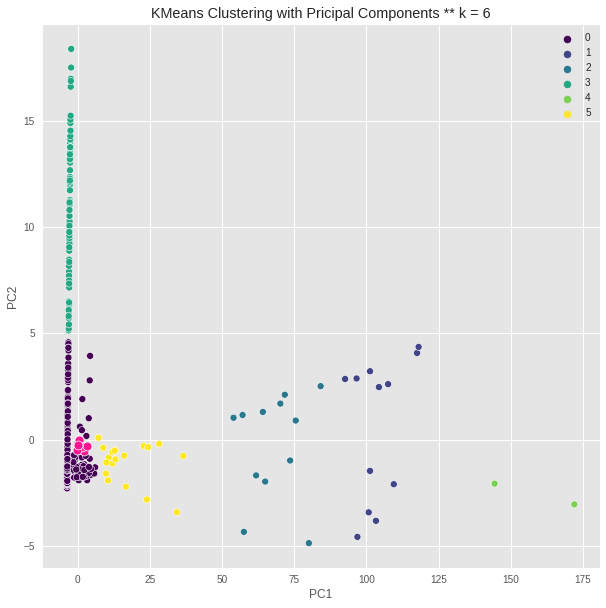

In [56]:
plt.figure(figsize = (10, 10))
plt.title('KMeans Clustering with Pricipal Components ** k = 6')
ax1 = sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'Cluster', data = final_data2_pca_df, 
                     palette = sns.color_palette('viridis', as_cmap = True))
ax2 = sns.scatterplot(centroids.iloc[:,0] , centroids.iloc[:,1] , s = 80, color = 'deeppink')
plt.show()